Setting up Spark and Basic data cleaning

In [110]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Create a Spark session
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()

# Check if SparkSession is created successfully
print(spark)

In [111]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pyspark.sql.functions import year, month, dayofmonth

In [113]:
file_path = 'data/DataCoSupplyChainDataset.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
# Some house cleaning where the the column names are standardized

for col in df.columns:
    new_col = col.replace(' ', '_').lower()
    df = df.withColumnRenamed(col, new_col)

df = df.withColumn("order_date", F.to_date(F.date_format(F.unix_timestamp("order_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumn("shipping_date", F.to_date(F.date_format(F.unix_timestamp("shipping_date_(dateorders)", "M/d/yyyy H:mm").cast("timestamp"), "yyyy-MM-dd")))
df = df.withColumnRenamed('days_for_shipping_(real)', 'actual_time')
df = df.withColumnRenamed('days_for_shipment_(scheduled)', 'predicted_time')
df = df.withColumn("o_year", year(df["order_date"])) \
       .withColumn("o_month", month(df["order_date"])) \
       .withColumn("o_day", dayofmonth(df["order_date"]))

df = df.withColumn("s_year", year(df["shipping_date"])) \
       .withColumn("s_month", month(df["shipping_date"])) \
       .withColumn("s_day", dayofmonth(df["shipping_date"]))

In [114]:
df = df.drop('product_image', 'customer_password', 'customer_email', 
             'customer_fname', 'customer_lname', 'customer_street', 
             'latitude', 'longitude', 'product_description',
             "order_date_(dateorders)", "shipping_date_(dateorders)",
             'days_for_shipment_(scheduled)', 'days_for_shipping_(real)')    
df.createOrReplaceTempView("my_table")
df.show(5)

+--------+-----------+--------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+--------------+----------------+-------------+---------------+------------+----------+-------------+-----------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+-------------+---------------+-------------------+------------+-------------+--------------+--------------+----------+-------------+------+-------+-----+------+-------+-----+
|    type|actual_time|predicted_time|benefit_per_order|sales_per_customer| delivery_status|late_delivery_risk|category_id| category_name|customer_city|customer_country|customer_id|customer_segment|customer_state|customer_zipcode|department_id|department_na

Calculating Lead time demands, lead time, safety stock and reporder points for each product

In [65]:
output = spark.sql("""
                    With T1 AS (
                    Select product_name, product_card_id, order_date,
                    sum(order_item_quantity) as quantity,
                    round(avg(actual_time),0) as lead_time_odate,
                    max(product_price) as p_price
                    From my_table
                    where o_year < 2017
                    group by product_name, product_card_id, order_date
                    )

                    Select product_name, product_card_id, 
                    round(avg(quantity),3) as avg_demand,
                    round(STDDEV(quantity),3) as std_dev_demand,
                    round(avg(lead_time_odate),0) as lead_time,
                    round(STDDEV(lead_time_odate),0) as stddev_lead_time,
                    round(lead_time * avg_demand,3) as lead_time_demand,
                    round(1.64*std_dev_demand*sqrt(lead_time),0) as safety_stock,
                    round(lead_time_demand+safety_stock,0) as reorder_point,
                    max(p_price) as price,
                    0.1*price as holding,
                    0.3*price as ordering,
                    Round(sqrt((2*avg_demand*365*ordering)/holding),0) as EOQ
                    from T1
                    group by product_name, product_card_id
                    order by avg_demand desc
                    """)
output.show(5)
output.toPandas().to_csv('product_SC_analysis.csv', index=False)

+--------------------+---------------+----------+--------------+---------+----------------+----------------+------------+-------------+-----------+------------------+------------------+-----+
|        product_name|product_card_id|avg_demand|std_dev_demand|lead_time|stddev_lead_time|lead_time_demand|safety_stock|reorder_point|      price|           holding|          ordering|  EOQ|
+--------------------+---------------+----------+--------------+---------+----------------+----------------+------------+-------------+-----------+------------------+------------------+-----+
|Perfect Fitness P...|            365|    73.722|        16.769|      4.0|             1.0|         294.888|        55.0|        350.0|59.99000168|       5.999000168|      17.997000504|402.0|
|Nike Men's Dri-FI...|            502|    62.516|        16.131|      4.0|             1.0|         250.064|        53.0|        303.0|       50.0|               5.0|              15.0|370.0|
|O'Brien Men's Neo...|           1014|  

* avg_demand = average quantity ordered per day for every product
* std_dev_demand = std. dev. of the daily quantity demanded for each product
* lead_time = average actual shipping time for every product
* lead_time_demand = lead_time * avg_demand
* safety_stock = 1.64 * std_dev_demand * sqrt(lead_time)
* reorder_point = lead_time_demand + safety_stock
* holding = 0.1*price
* ordering = 0.3*price
* EOQ = Round(sqrt((2 * (avg_demand * 365) * ordering)/holding),0)

If we are looking at data only before 2017 then there are just 54 products being sold.

## Obtaining Forcasts

In [89]:
xx = spark.sql("""
            Select product_name, product_card_id,
            sum(order_item_quantity) as quantity
            From my_table
            where o_year < 2017
            group by product_name, product_card_id
            order by quantity desc
        """).toPandas()
prod_list = xx['product_card_id']

In [101]:
def forecast(id, initial_year, final_year):
    query1 = f"""
            CREATE OR REPLACE TEMPORARY VIEW actual AS
            Select order_date as ds,
            sum(order_item_quantity) as y
            From my_table
            Where product_card_id = {id}
            AND o_year Between {initial_year} and {final_year}
            group by ds
            order by ds
        """
    
    spark.sql(query1)
    
    query2 = f"""
        SELECT order_date as ds,
               SUM(order_item_quantity) as y
        FROM my_table
        WHERE product_card_id = {id}
          AND o_year < {initial_year}
        GROUP BY order_date
        ORDER BY order_date
    """
    prophet_df = spark.sql(query2).toPandas()

    prophet = Prophet()
    prophet.fit(prophet_df)
    # Create a DataFrame with future dates for forecasting
    future = prophet.make_future_dataframe(periods=30, freq='D')
    # Generate forecasts
    forecast = prophet.predict(future) 
    

    spark_df = spark.createDataFrame(forecast)
    spark_df.createOrReplaceTempView("predicted")
    query3 = f"""
            CREATE OR REPLACE TEMPORARY VIEW predicted_filter AS
            Select ds, yhat
            from predicted
            where ds >= '{initial_year}-01-01'
            """
    spark.sql(query3)
    query4 = f"""
            select {id} as product_card_id, p.*, a.y
            from predicted_filter as p
            left join actual as a on a.ds = p.ds
            """
    
    results = spark.sql(query4).toPandas()

    return results


In [102]:
final_df = pd.DataFrame()

for id in prod_list:
    results = forecast(id,2017,2018)    
    final_df = pd.concat([final_df, results], ignore_index=True)

00:59:08 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:09 - cmdstanpy - INFO - Chain [1] done processing
00:59:11 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:11 - cmdstanpy - INFO - Chain [1] done processing
00:59:13 - cmdstanpy - INFO - Chain [1] start processing
00:59:13 - cmdstanpy - INFO - Chain [1] done processing
00:59:15 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:15 - cmdstanpy - INFO - Chain [1] done processing
00:59:18 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:18 - cmdstanpy - INFO - Chain [1] done processing
00:59:21 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:21 - cmdstanpy - INFO - Chain [1] done processing
00:59:23 - cmdstanpy - INFO - Chain [1] start processing                        
00:59:23 - cmdstanpy - INFO - Chain [1] done processing
00:59:25 - cmdstanpy - INFO - Chain [1] start processing
00:59:25

In [97]:
final_df.to_csv('forecasts.csv', index=False)

Visualize for a product of your choice

In [106]:
results = final_df[final_df['product_card_id'] == 191]
results.head(5)

,product_card_id,ds,yhat,y
90,191,2017-01-01,34.357626,44.0
91,191,2017-01-02,34.154553,45.0
92,191,2017-01-03,33.862044,24.0
93,191,2017-01-04,34.341459,41.0
94,191,2017-01-05,33.091643,40.0


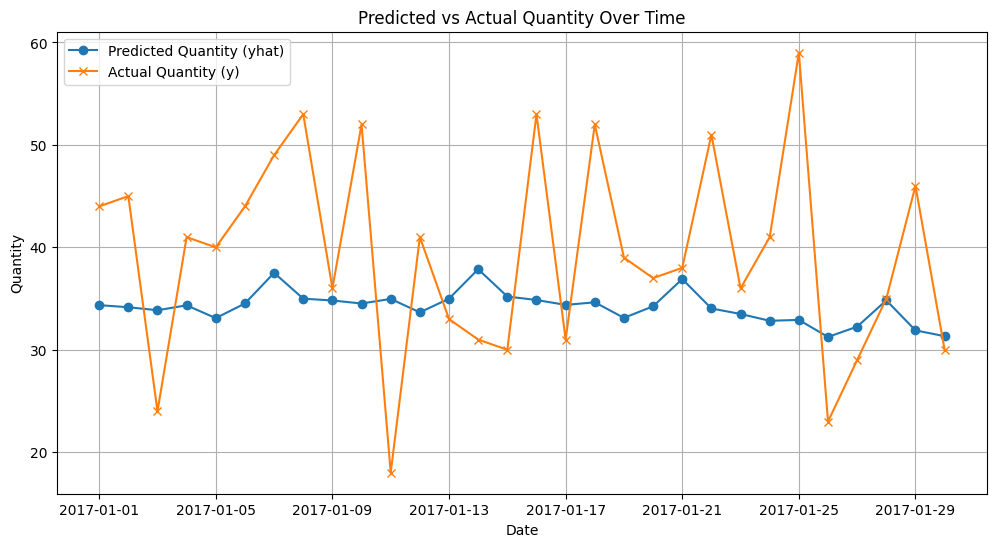

In [107]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results['ds'], results['yhat'], label='Predicted Quantity (yhat)', marker='o')
plt.plot(results['ds'], results['y'], label='Actual Quantity (y)', marker='x')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Predicted vs Actual Quantity Over Time')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

## Further Data Analysis

Checking for Association

In [118]:
orders = spark.sql("""
            SELECT 
                order_id,
                collect_list(product_card_id) AS product_ids
            FROM 
                my_table
            GROUP BY 
                order_id;
          """)
# orders.show(10)
orders = orders.toPandas()['product_ids']
# to_csv('order_details.csv', encoding='utf-8', index=False)

dataset = []

for row in orders:
    dataset.append(row)
dataset[0]

[957]

In [120]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [121]:
oht = TransactionEncoder() 
oht_array = oht.fit(dataset).transform(dataset) 
oht_df = pd.DataFrame(oht_array, columns = oht.columns_) 
# oht_df.to_csv('transaction_encoded.csv', index=False)

In [140]:
frequent_items = apriori(oht_df, min_support = 0.01, use_colnames = True)
frequent_items = frequent_items.sort_values(by = ['support'], ascending = False)
frequent_items


,support,itemsets
1,0.309633,(365)
2,0.285664,(403)
3,0.271764,(502)
7,0.252814,(1014)
6,0.230624,(1004)
...,...,...
55,0.010251,"(1004, 1014, 191)"
95,0.010220,"(1073, 957, 1014)"
87,0.010190,"(627, 1014, 502)"
67,0.010144,"(627, 1004, 365)"


In [141]:
fs = frequent_items['itemsets'][18]

In [142]:
query = f"""Select distinct(product_name)
          from my_table
          where product_card_id IN ({', '.join(map(str, fs))})
          """
print(query)
spark.sql(query).toPandas()

Select distinct(product_name)
          from my_table
          where product_card_id IN (403, 365)
          


/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/Users/sunith/opt/anaconda3/envs/dss/lib/python3.12/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):


,product_name
0,Perfect Fitness Perfect Rip Deck
1,Nike Men's CJ Elite 2 TD Football Cleat
